# Setup Package

In [1]:
import torch as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt, seaborn as sns
import missingno as msno

# Data Visualizaton

## ETTm2

In [2]:
df_ettm2=pd.read_csv("Data/ETTm2.csv")

### Cetak Missing Value

<Axes: >

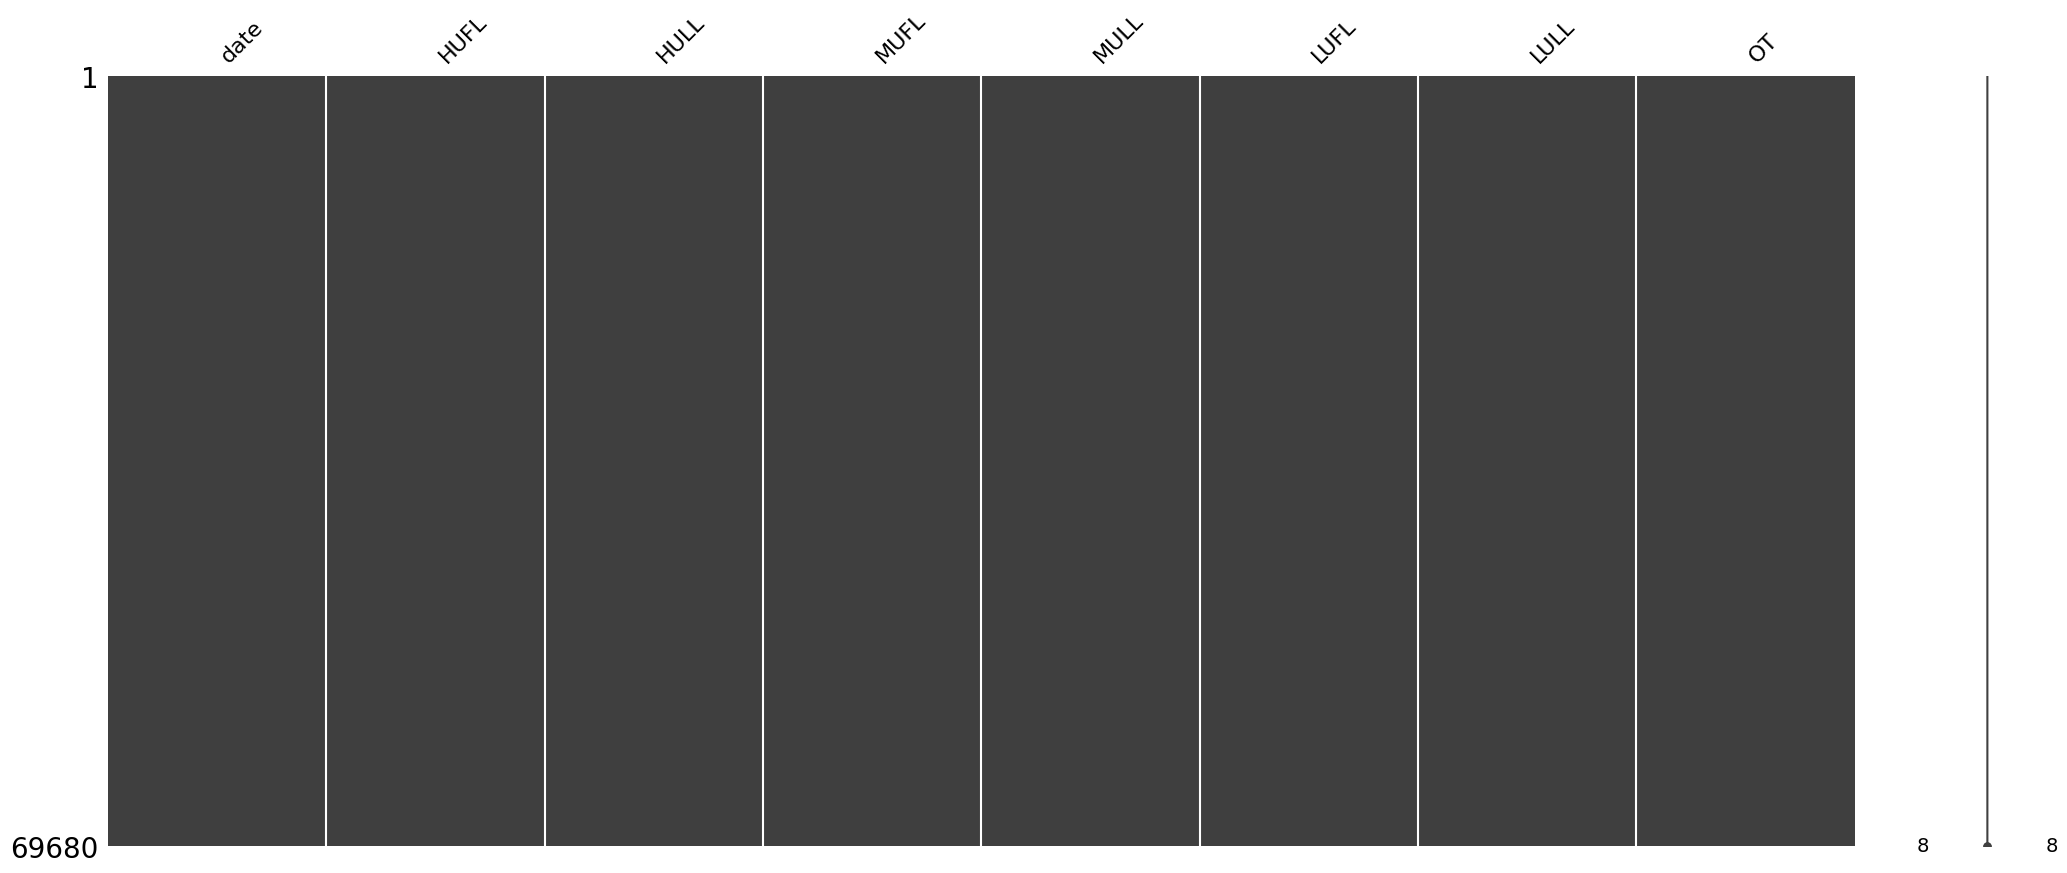

In [3]:
msno.matrix(df_ettm2)

### Cetak Korelasi

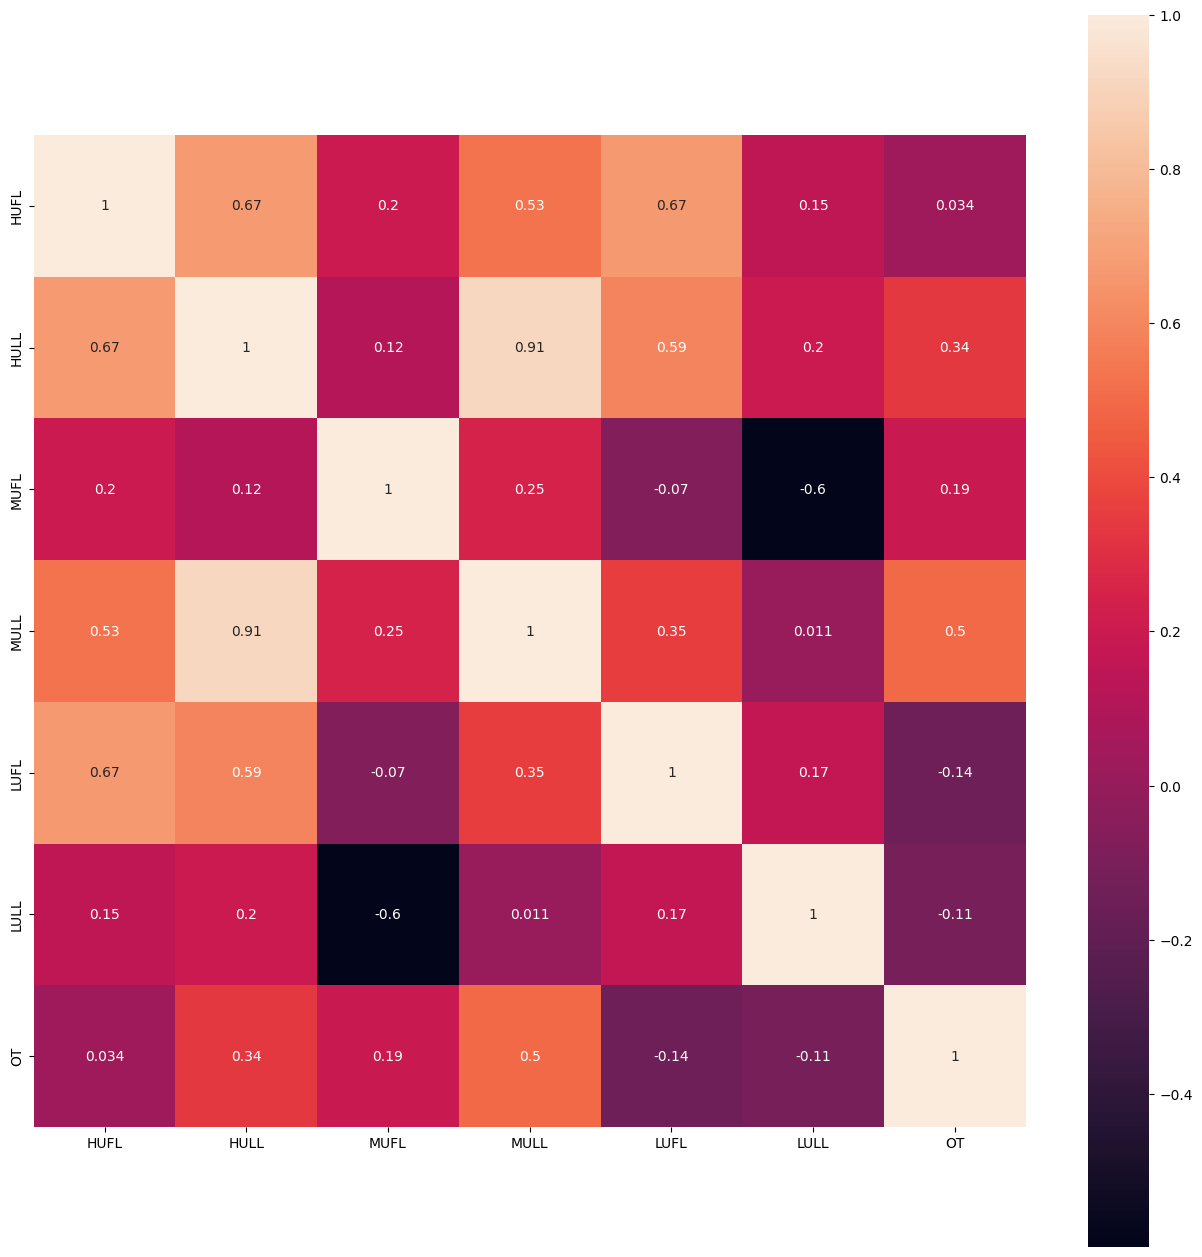

In [4]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_ettm2.corr(numeric_only = True), annot=True, square=True)
plt.show()

### Cetak Grafik

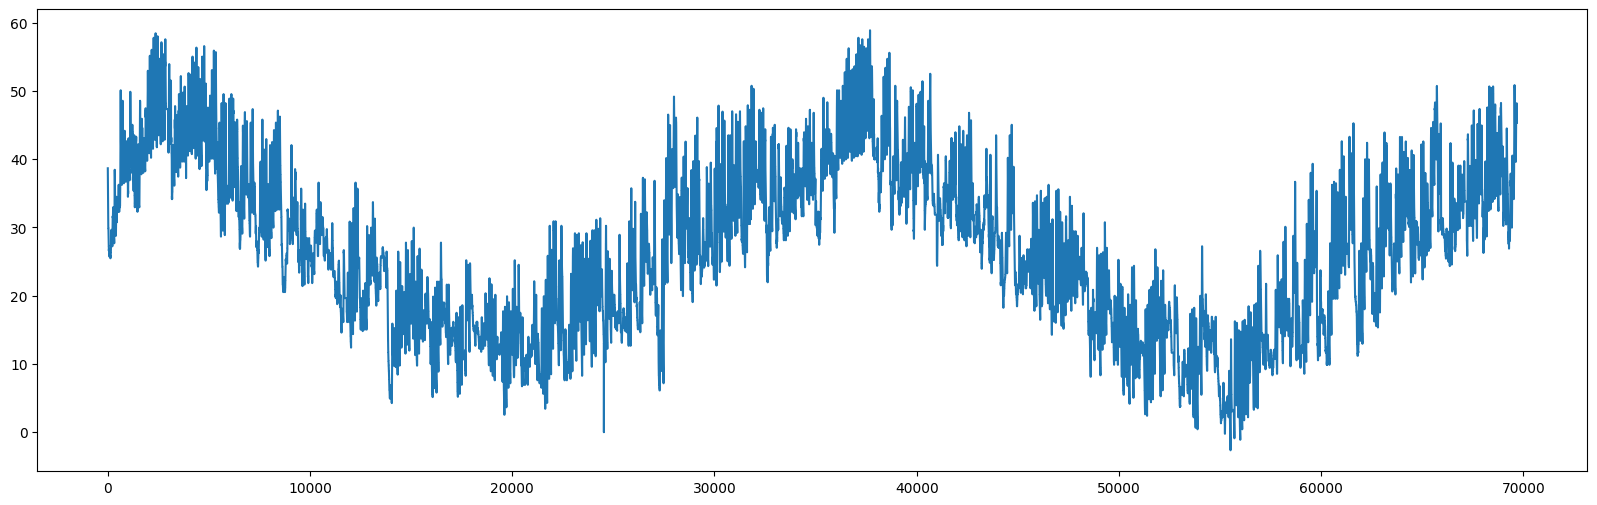

In [5]:
plt.figure(figsize=(20,6))
plt.plot(df_ettm2["OT"].to_numpy())

## Turbine Dataset

In [6]:
df_turbine=pd.read_csv("Data/Turbine_Data.csv")

### Cetak Missing Value

<Axes: >

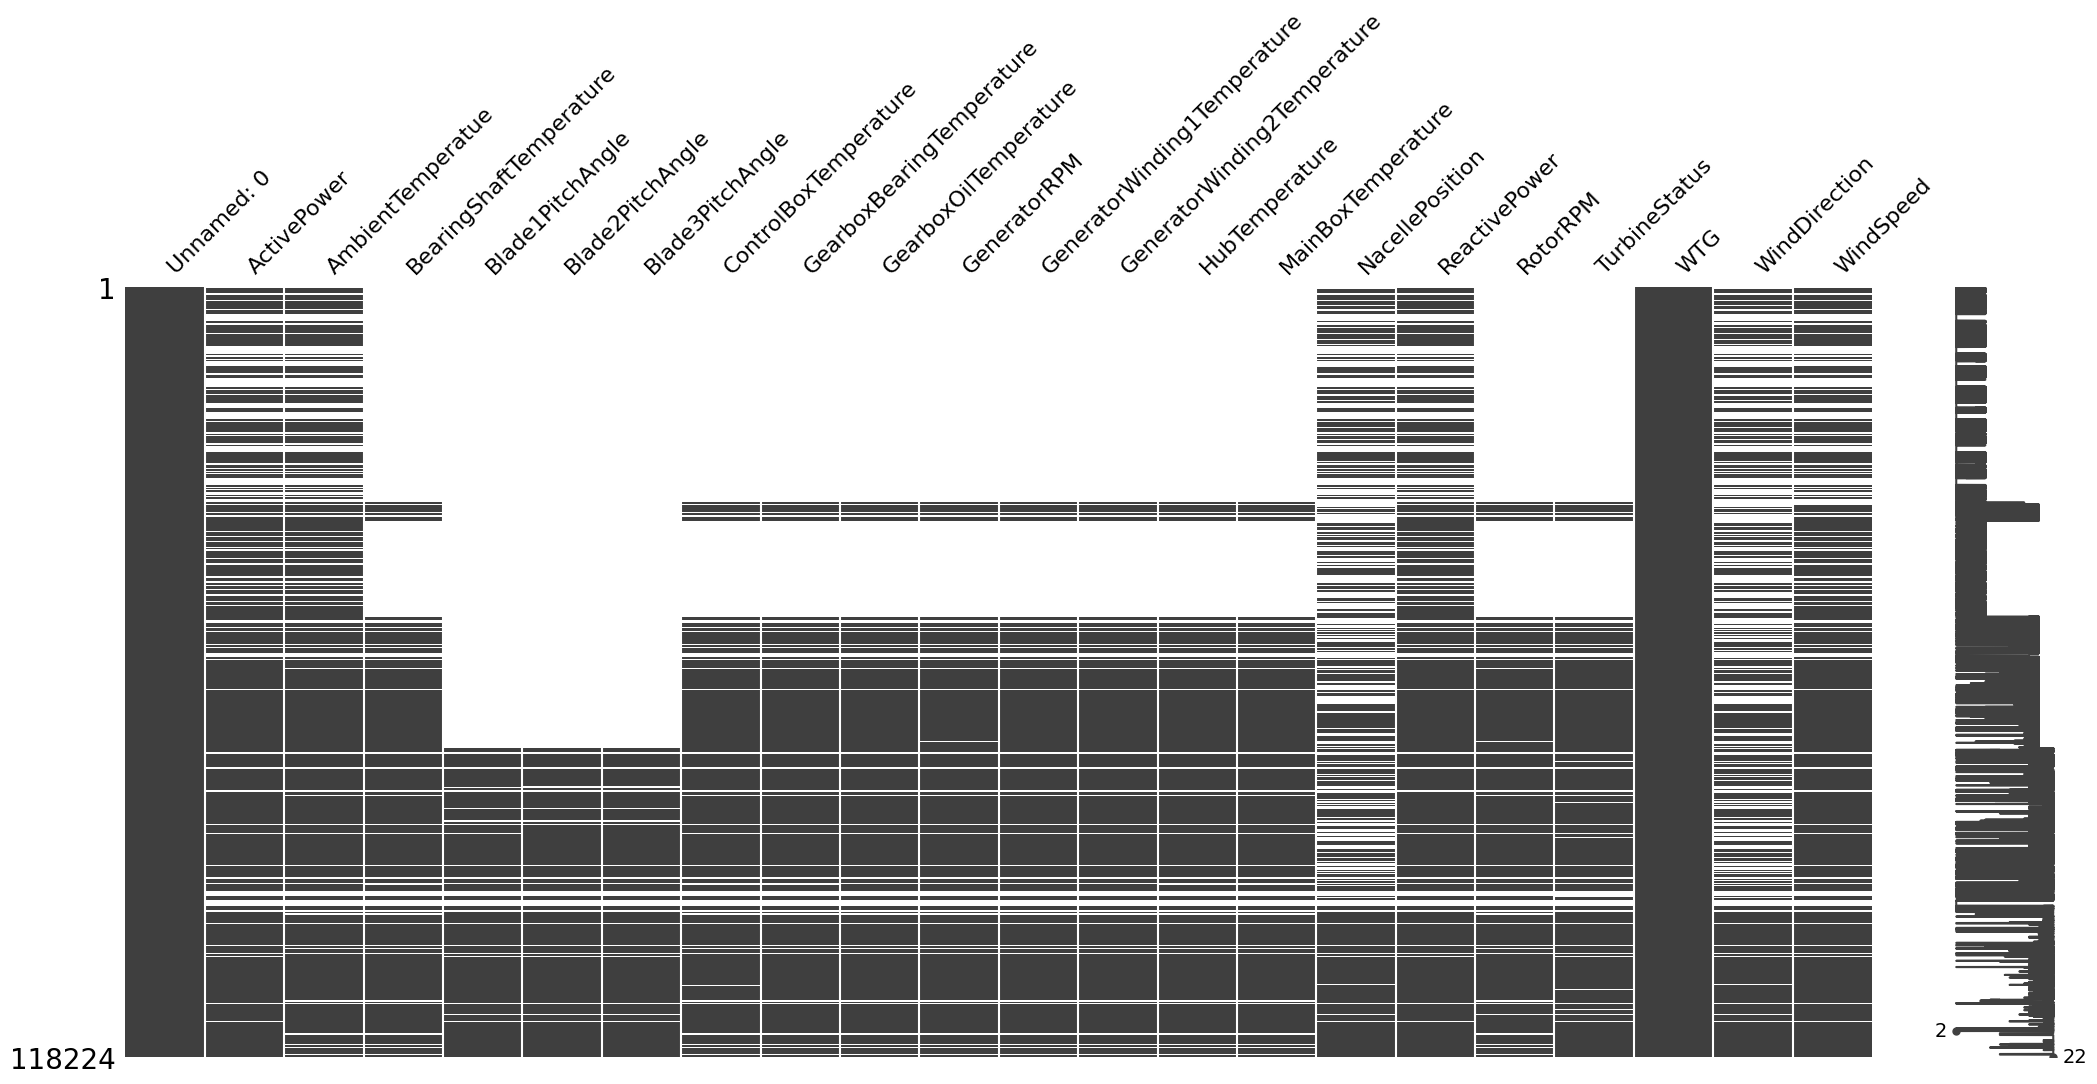

In [7]:
#the dataset shows 118224 observations for 22 features but some of the features have significant periods of missing data. We need to discard some periods and fill in the missing periods, otherwise our LSTM model will not converge or we may end up feeding it with garbage data.
#the rightmost part of the msno matrix plot shows completess of data, it indicates that the last half of dataset is more complete. We will strive to use this part for training and testing.
msno.matrix(df_turbine)

### Cek Korelasi

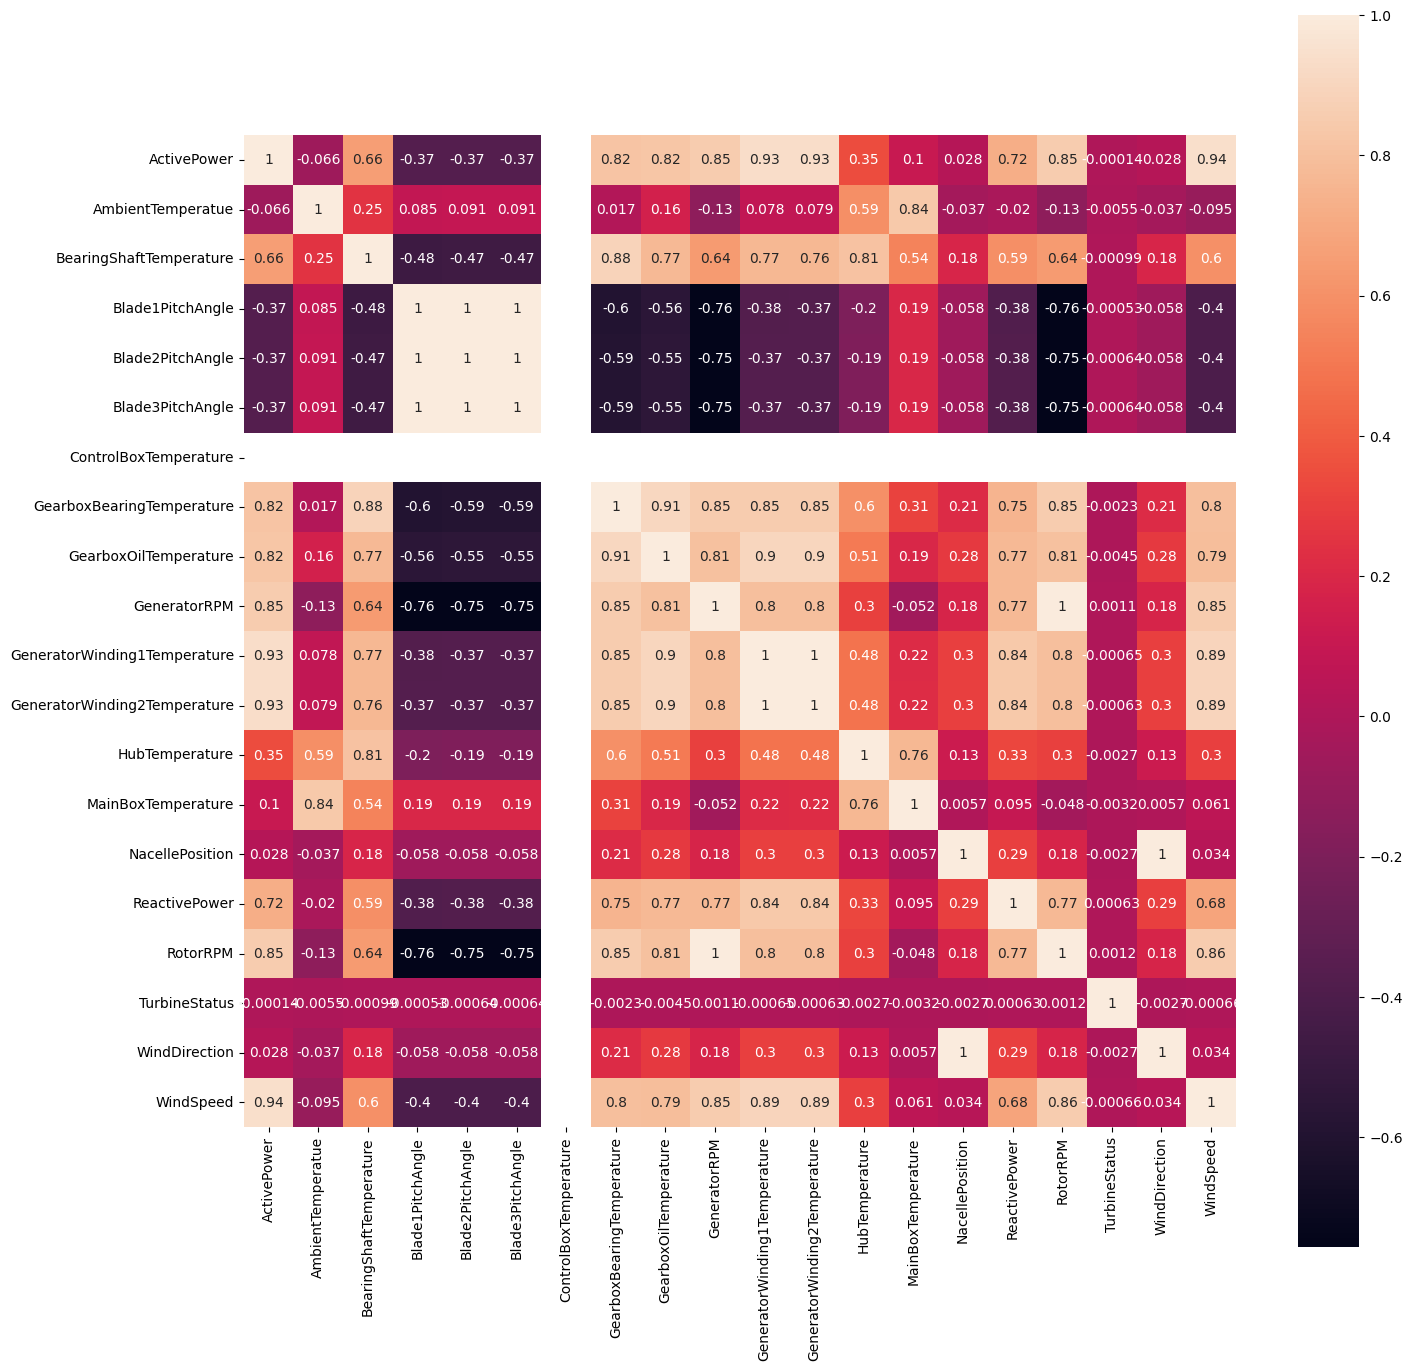

In [8]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_turbine.corr(numeric_only = True), annot=True, square=True)
plt.show()

Terdapat 2 data yang berkorelasi kuat:
- Windspeed 
- ActivePower

### Cetak Grafik

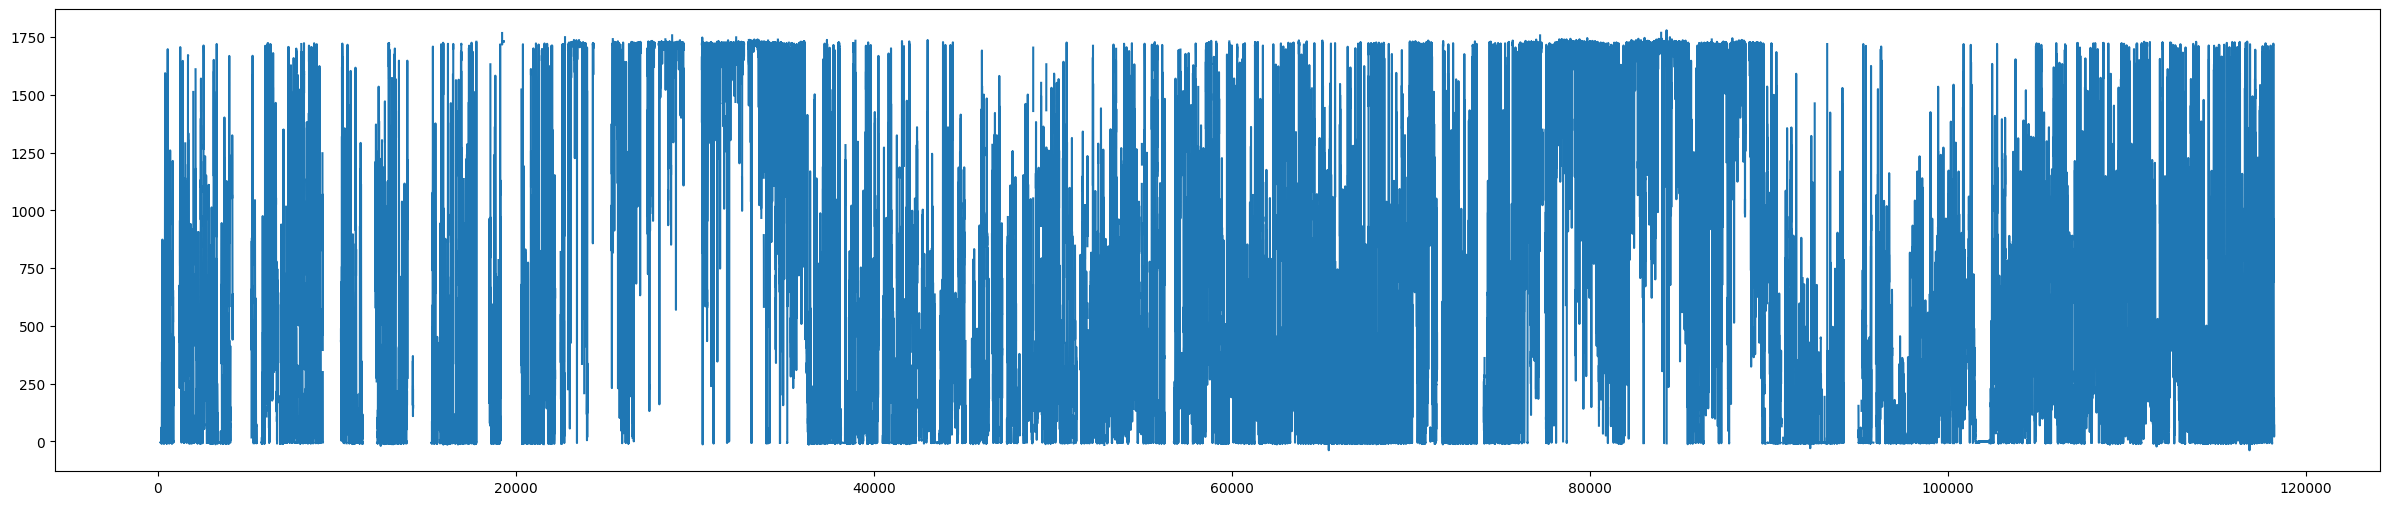

In [9]:
plt.figure(figsize=(30,6))
plt.plot(df_turbine["ActivePower"].to_numpy())

## M4 Dataset

In [10]:
df_m4=pd.read_csv("Data/m4/Yearly-train.csv")

In [11]:
df_m4=df_m4.iloc[:, 0:10]

In [12]:
df_m4.shape

(23000, 10)

### Cetak Missing Value

<Axes: >

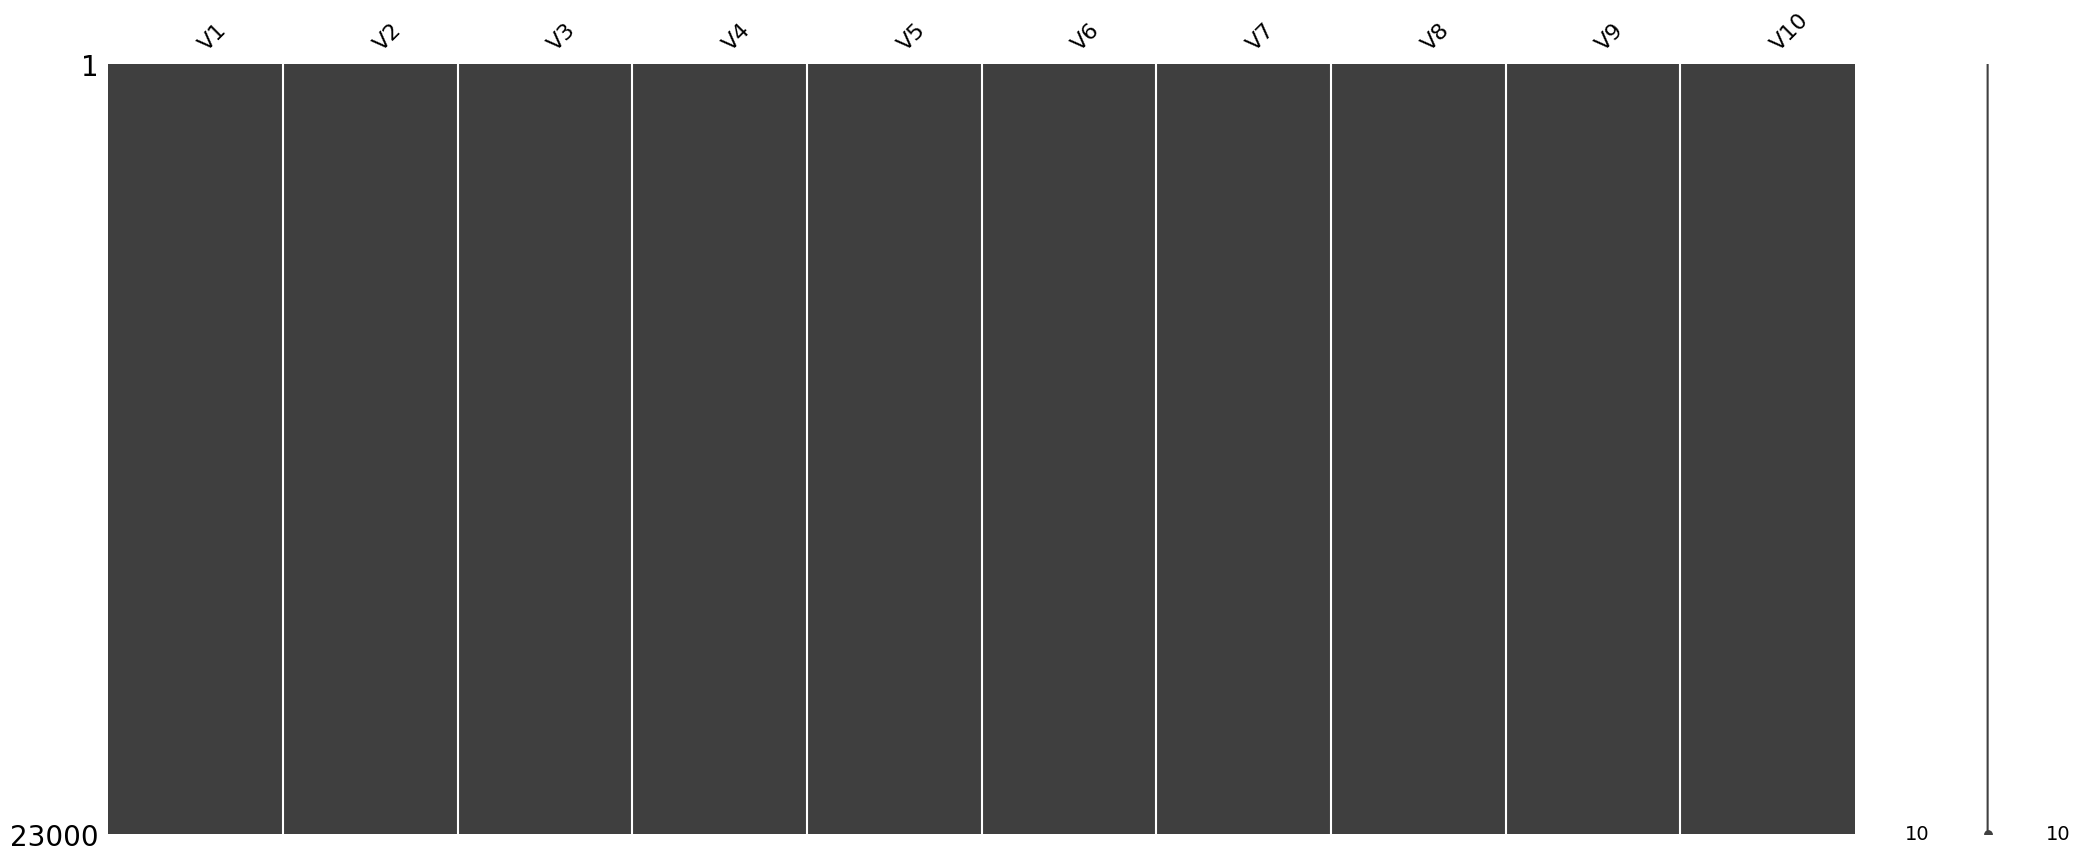

In [13]:
msno.matrix(df_m4)

### Cetak Korelasi

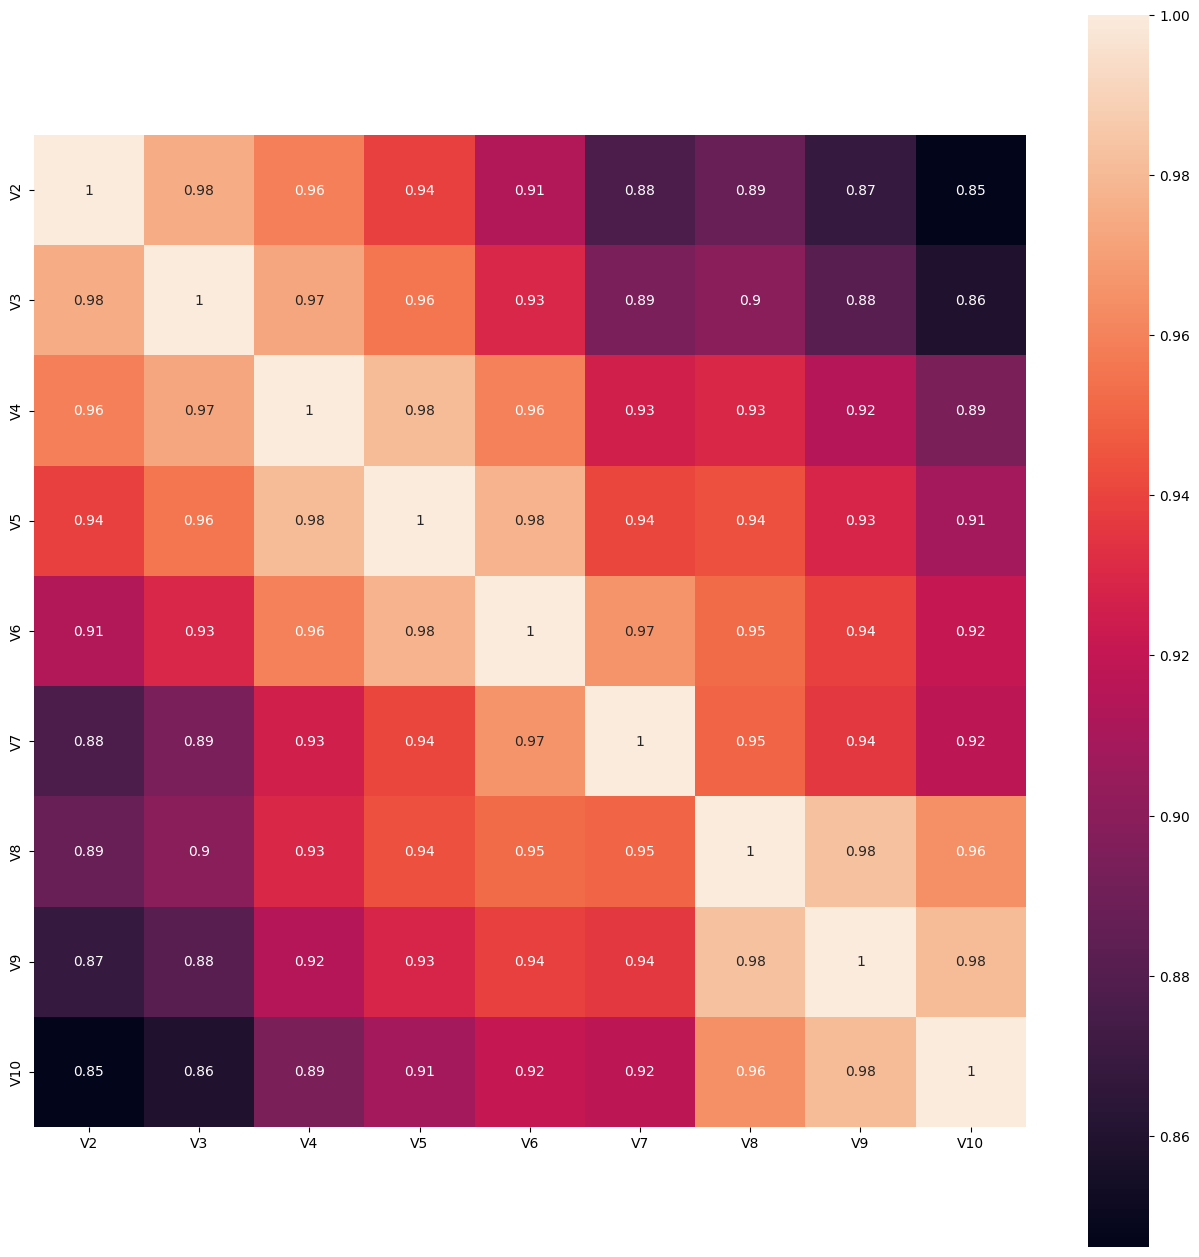

In [14]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df_m4.corr(numeric_only = True), annot=True, square=True)
plt.show()

### Cetak grafik

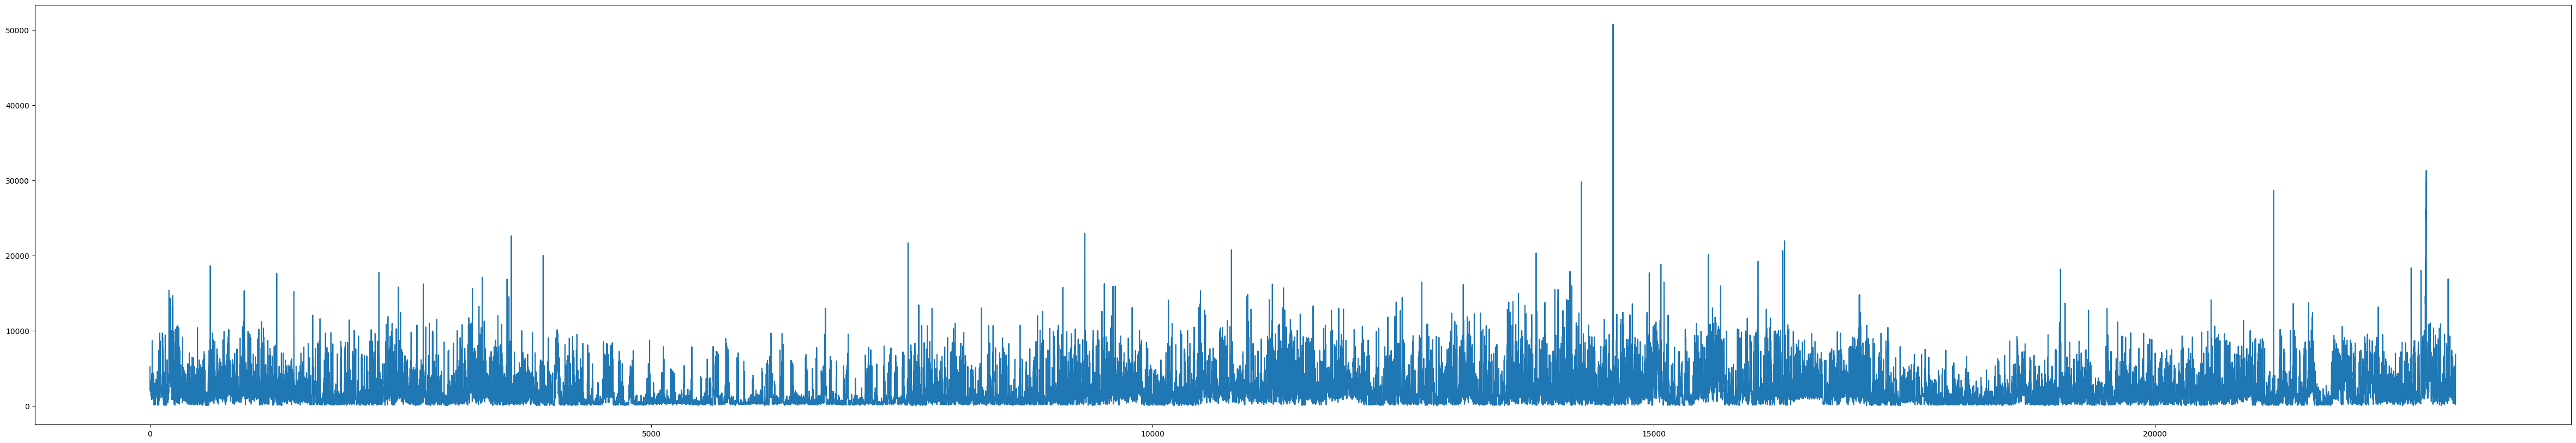

In [15]:
plt.figure(figsize=(60,10))
plt.plot(df_m4["V2"].to_numpy())

In [16]:
df_m4["V2"]

0        5172.1
1        2070.0
2        2760.0
3        3380.0
4        1980.0
          ...  
22995     470.0
22996    4660.0
22997     688.8
22998     147.0
22999    6850.0
Name: V2, Length: 23000, dtype: float64

# Manualisasi Hitungan

In [17]:
import torch
import torch.nn as nn

In [18]:
input_manual=df_m4["V2"][:7].to_numpy()
input_manual

array([5172.1 , 2070.  , 2760.  , 3380.  , 1980.  , 1988.65, 2158.96])

## Normalisasi

In [19]:
from sklearn.preprocessing import MinMaxScaler
 
scaler=MinMaxScaler(feature_range=(-1,1))
normalized_manual=scaler.fit_transform(input_manual.reshape(-1, 1))
# normalized_manual=normalized_manual.flatten()
normalized_manual

array([[ 1.        ],
       [-0.94361079],
       [-0.51129351],
       [-0.1228345 ],
       [-1.        ],
       [-0.99458037],
       [-0.88787319]])

In [20]:
x=normalized_manual[:5]
y=normalized_manual[4:6]
y

array([[-1.        ],
       [-0.99458037]])

## Positional Encoding

In [21]:
import numpy as np

def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * np.arange(d_model)[np.newaxis, :]) / np.float32(d_model))
    # Sine untuk indeks genap
    sines = np.sin(angle_rads[:, 0::2])
    
    # Cosine untuk indeks ganjil
    cosines = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return pos_encoding

# d_model = 1
d_model = 1
position =5

pos_encoding_x = positional_encoding(5, d_model)
pos_encoding_y = positional_encoding(2, d_model)


In [22]:
print("print positional encoding for x")
print(x)
print(pos_encoding_x)
x_encoded=x+pos_encoding_x
print("hasil x_encoded")
print(x_encoded)

print positional encoding for x
[[ 1.        ]
 [-0.94361079]
 [-0.51129351]
 [-0.1228345 ]
 [-1.        ]]
[[ 0.        ]
 [ 0.84147098]
 [ 0.90929743]
 [ 0.14112001]
 [-0.7568025 ]]
hasil x_encoded
[[ 1.        ]
 [-0.1021398 ]
 [ 0.39800392]
 [ 0.01828551]
 [-1.7568025 ]]


In [23]:
print("print positional encoding for y")
print(y)
print(pos_encoding_y)
y_encoded=y+pos_encoding_y
print("hasil y_encoded")
print(y_encoded)

print positional encoding for y
[[-1.        ]
 [-0.99458037]]
[[0.        ]
 [0.84147098]]
hasil y_encoded
[[-1.        ]
 [-0.15310939]]


### Attention

In [54]:
np.random.seed(42)
QVK = np.random.uniform(-1, 1, (3, 1))
bias = np.random.uniform(-1, 1, (3, 1))
print("qvk")
print(QVK)
print("bias")
print(bias)

qvk
[[-0.25091976]
 [ 0.90142861]
 [ 0.46398788]]
bias
[[ 0.19731697]
 [-0.68796272]
 [-0.68801096]]


In [82]:
ENCODEDdotEVK=np.dot(x_encoded,np.transpose(QVK))+np.transpose(bias)
print(ENCODEDdotEVK)

[[-0.05360279  0.21346589 -0.22402308]
 [ 0.22294586 -0.78003446 -0.73540259]
 [ 0.09744992 -0.3291906  -0.50334196]
 [ 0.19272877 -0.67147964 -0.6795267 ]
 [ 0.63813343 -2.27159476 -1.50314603]]


In [83]:
Qmat=ENCODEDdotEVK[::,0].reshape(-1,1)
Vmat=ENCODEDdotEVK[::,1].reshape(-1,1)
Kmat=ENCODEDdotEVK[::,2].reshape(-1,1)
print(Qmat)
print(Vmat)
print(Kmat)

[[-0.05360279]
 [ 0.22294586]
 [ 0.09744992]
 [ 0.19272877]
 [ 0.63813343]]
[[ 0.21346589]
 [-0.78003446]
 [-0.3291906 ]
 [-0.67147964]
 [-2.27159476]]
[[-0.22402308]
 [-0.73540259]
 [-0.50334196]
 [-0.6795267 ]
 [-1.50314603]]


In [86]:
Attention=np.dot(np.dot(Qmat,np.transpose(Kmat)),Kmat)
Attention

array([[-0.19112403],
       [ 0.79492707],
       [ 0.34746363],
       [ 0.68718619],
       [ 2.27530366]])